In [11]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

from cfollmer.objectives import log_g, relative_entropy_control_cost, gaussian_prior
from cfollmer.sampler_utils import FollmerSDE
import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

## Generating Toy 2D Dataset.

In [21]:
import torch
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
random_state = 170

X, y = make_blobs(n_samples=100,
                  cluster_std=[0.5, 0.5, 0.5],
                  random_state=random_state)


# # Scale data to have mean 0 and variance 1 
# # which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)


X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

In [22]:
X.shape

(100, 2)

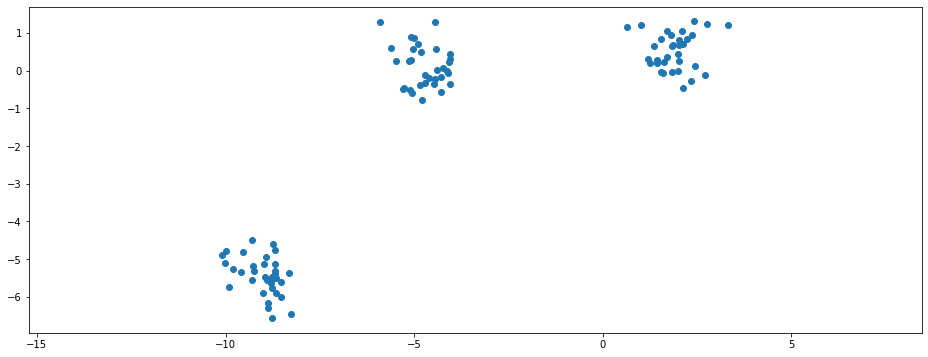

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

ax1.plot(X[:, 0], X[:, 1], 
         linestyle='none', 
         marker='o')

ax1.axis('equal');

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation.

In [62]:
def log_gaussian(x, mean=0):
    """
    Returns the density of x under the supplied gaussian. Defaults to
    standard gaussian N(0, I)
    :param x: (*) torch.Tensor
    :param mean: float or torch.FloatTensor with dimensions (*)
    :param logvar: float or torch.FloatTensor with dimensions (*)
    :return: (*) elementwise log density
    """
    
    log_norm_constant = -0.5 * np.log(2 * np.pi)
    logvar = 0.0
    logvar = x.new(1).fill_(logvar)
    
    a = (x - mean) ** 2
    log_p = -0.5 * (logvar + a / logvar.exp())
    log_p = log_p + log_norm_constant

    return log_p.sum(dim=-1)


def log_likelihood_single(μ, X, log=True):
    """
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :param log: return value in log domain?

    """
#     import pdb; pdb.set_trace()
    
    n, d = X.shape
    # get feature-wise log-likelihoods (K, examples, features)
    log_likelihoods = log_gaussian(
        X[None, :, :], # (1, examples, features)
        μ.reshape(-1, d)[:, None, :], # (K, 1, features)
    )

    # sum over the feature dimension
    log_likelihoods = torch.logsumexp(log_likelihoods, dim=0) 

    return log_likelihoods.sum()


def log_likelihood(Θ, X, y=None):
    """
    batching the above (hopefully its right)
    """
#     import pdb; pdb.set_trace()
    loss_ = lambda μ: log_likelihood_single(μ, X)
    
    batched_loss =  torch._vmap_internals.vmap(loss_)

    return batched_loss(Θ)

In [63]:
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
dim = 3 * 2

ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 50

sde = FollmerSDE(dim, dim, no_posterior_samples, 1.0, device=device).to(device)
Θ_0 = torch.zeros((no_posterior_samples, dim)).to(device) # Θ_0 ~ δ_0

# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)

In [64]:
relative_entropy_control_cost(sde, Θ_0, X_train, y_train, 
                              gaussian_prior, log_likelihood, γ=1.0, device=device)

<ipython-input-62-e57240e7333f>:40: UserWarning: Batching rule not implemented for aten::logsumexp falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  log_likelihoods = torch.logsumexp(log_likelihoods, dim=0)
<ipython-input-62-e57240e7333f>:42: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum()


tensor(253.8604, device='cuda:0', grad_fn=<MeanBackward0>)

In [66]:
γ = 1.0
Δt=0.05
t_size = int(math.ceil(1.0/Δt))
print(t_size)
ts = torch.linspace(0, 1, t_size).to(device)

sde = FollmerSDE(dim, dim, no_posterior_samples  , γ=γ, device=device).to(device)
optimizer = torch.optim.Adam(sde.μ.parameters(), lr=0.05, weight_decay =1)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)
losses = []
num_steps = 100
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer, torch.optim.LBFGS):
        def closure():
            loss = relative_entropy_control_cost(
                sde, Θ_0.float(),
                X_train.float(), y_train.float(),
                gaussian_prior, log_likelihood, γ=γ
            )
            optimizer.zero_grad()
            loss.backward()
            return loss

        optimizer.step(closure)
        losses.append(closure().item())
    else:
        loss = relative_entropy_control_cost(
            sde, Θ_0,
            X_train, y_train,
            gaussian_prior, log_likelihood, γ=γ
        )
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        losses.append(loss.item())

20


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-62-e57240e7333f>:40: UserWarning: Batching rule not implemented for aten::logsumexp falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  log_likelihoods = torch.logsumexp(log_likelihoods, dim=0)
<ipython-input-62-e57240e7333f>:42: UserWarning: Batching rule not implemented for aten::sum falling back to slow (for loop and stack) implementation (Triggered internally at  ..\aten\src\ATen\BatchedFallback.cpp:63.)
  return log_likelihoods.sum()


In [67]:
losses

[197.25466918945312,
 185.0006866455078,
 193.5955047607422,
 178.78802490234375,
 198.6876983642578,
 197.59375,
 178.87034606933594,
 181.782958984375,
 190.6962432861328,
 190.71487426757812,
 187.43624877929688,
 169.47537231445312,
 182.07687377929688,
 189.39019775390625,
 191.61517333984375,
 194.22183227539062,
 185.1580352783203,
 202.19407653808594,
 187.38619995117188,
 182.9688262939453,
 191.2444610595703,
 195.79884338378906,
 178.8206024169922,
 191.23431396484375,
 180.2606201171875,
 185.2538604736328,
 192.85446166992188,
 186.71983337402344,
 178.7323760986328,
 185.0272216796875,
 183.6731414794922,
 190.0636749267578,
 174.44422912597656,
 185.08995056152344,
 171.4921112060547,
 178.1132049560547,
 188.98397827148438,
 186.468505859375,
 178.737548828125,
 182.2809295654297,
 179.78366088867188,
 185.1968536376953,
 190.79730224609375,
 183.9984130859375,
 191.259033203125,
 187.58401489257812,
 203.00363159179688,
 185.4540252685547,
 193.966552734375,
 184.43058

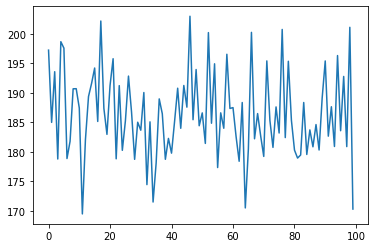

In [68]:
plt.plot(losses[:])

In [11]:
 torchsde.sdeint(sde, Θ_0, ts, method="euler", dt=Δt).shape

torch.Size([20, 50, 3])

In [12]:
X_train.shape

torch.Size([80, 3])

In [13]:
Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([ 2.,  3.,  6., 11.,  7., 12.,  5.,  1.,  2.,  1.]),
 array([0.5873247, 1.0273933, 1.4674621, 1.9075307, 2.3475993, 2.787668 ,
        3.2277367, 3.6678054, 4.107874 , 4.5479426, 4.9880114],
       dtype=float32),
 <a list of 10 Patch objects>)

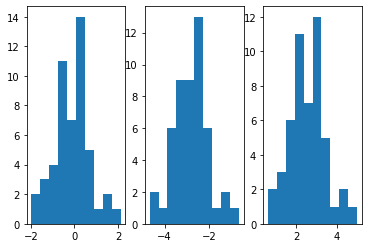

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
ax3.hist(Θ_1[:,2].cpu().detach().numpy())

In [15]:
pred = torch.sigmoid(X_train.mm(Θ_1.T)).mean(axis=1)

In [16]:
((pred < 0.5).float() == y_train).float().mean()

tensor(0.9875, device='cuda:0')

In [17]:
pred_test = torch.sigmoid(X_test.float().mm(Θ_1.T)).mean(axis=1)

In [18]:
((pred_test < 0.5).float() == y_test).float().mean()

tensor(1., device='cuda:0')

In [19]:
Θ_1.mean(axis=0)

tensor([-0.0865, -2.8009,  2.5684], device='cuda:0', grad_fn=<MeanBackward1>)

In [20]:
y_test, (pred_test < 0.5).long()

(tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.,
         1., 1.], device='cuda:0'),
 tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1],
        device='cuda:0'))

## MAP Baseline

We run the point estimate approximation (Maximum a posteriori) to double check what the learned weights look like.  We get the  exact same training accuracy as with the controlled model and similarly large weights for the non bias weights. 

In [22]:
Θ_map = torch.full((1, dim), 0.0, requires_grad=True)  
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, (X_train).float(), (y_train).float()) + gaussian_prior(Θ_map))
        optimizer_map.zero_grad()
        loss_map.backward()

        optimizer_map.step()
        losses_map.append(loss.item())

Θ_map
pred_map = torch.sigmoid(X_train.float().mm(Θ_map.T)).mean(axis=1)
((pred_map < 0.5).float() == y_train).float().mean(), Θ_map

  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat2 in method wrapper_mm)